<a id="section-one"></a>
# Introduction




In [1]:
import time
from PIL import Image
import os
import cv2
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from torch.autograd import Variable
from collections import OrderedDict
import torchvision
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
import torchvision.transforms as transforms
from torchvision import datasets

from torch.utils.data import Dataset,DataLoader
from itertools import accumulate
from functools import reduce


from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

# import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import json

In [2]:
train_data = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
print('Total nuber of images in the dataset', len(train_data))
train_data.head()

Total nuber of images in the dataset 21397


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
with open('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
    labels = json.load(f)
labels

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

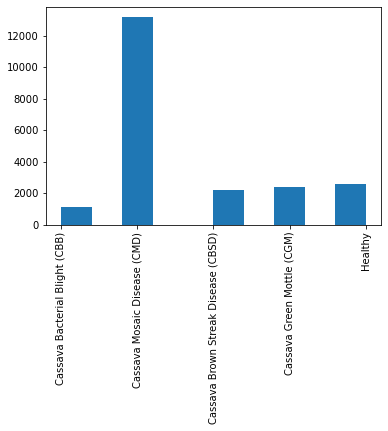

In [4]:
data = train_data['label'].astype(str).map(labels)
p = plt.hist(data)
plt.xticks(rotation='vertical')

plt.show()

<a id="section-two"></a>
# Transfer learning 

Transfer learning always helps as a pre-trained model had already learnt the high level features. Selecting the VGG-19 model for initial modelling and visualization


<a id="subsection-oneintwo"></a>
## Loading the model

In [5]:
model_urls = {
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',    
}

model_names = model_urls.keys()

input_sizes = {
    'vgg' : (224,224)
}

batch_size = 20
use_gpu = torch.cuda.is_available()

In [6]:
#Sanity check that param names overlap
#Note that params are not necessarily in the same order for every pretrained model
def diff_states(dict_canonical, dict_subset):
    names1, names2 = (list(dict_canonical.keys()), list(dict_subset.keys()))
    not_in_1 = [n for n in names1 if n not in names2]
    not_in_2 = [n for n in names2 if n not in names1]
    assert len(not_in_1) == 0
    assert len(not_in_2) == 0

    for name, v1 in dict_canonical.items():
        v2 = dict_subset[name]
        assert hasattr(v2, 'size')
        if v1.size() != v2.size():
            yield (name, v1)          

In [7]:
#loading and finding the different states in the model and merging them
def load_defined_model(name, num_classes):
    
    model = models.__dict__[name](num_classes=num_classes)
    
    pretrained_state = model_zoo.load_url(model_urls[name])

    #Diff
    diff = [s for s in diff_states(model.state_dict(), pretrained_state)]
    print("Replacing the following state from initialized", name, ":", \
          [d[0] for d in diff])
    
    for name, value in diff:
        pretrained_state[name] = value
    
    assert len([s for s in diff_states(model.state_dict(), pretrained_state)]) == 0
    
    #Merge
    model.load_state_dict(pretrained_state)
    return model, diff

In [8]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/'):
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = CassavaDataset(train_, data_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=20,
        pin_memory=False,
        drop_last=False,
        shuffle=True
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=20,
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

In [9]:
def filtered_params(net, param_list=None):
    def in_param_list(s):
        for p in param_list:
            if s.endswith(p):
                return True
        return False    
    #Caution: DataParallel prefixes '.module' to every parameter name
    params = net.named_parameters() if param_list is None \
    else (p for p in net.named_parameters() if in_param_list(p[0]))
    return params

In [10]:

def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


class CassavaDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (224,224),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 }
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        
        if output_label == True:
            self.labels = self.df['label'].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df['label'].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index]['image_id']))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix]['image_id']))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/224/224
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((224, 224), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (224* 224))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

<a id="subsection-twointwo"></a>
## Training and Validation

In [11]:
# Data augmentation
from albumentations.augmentations.transforms import CLAHE
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            RandomResizedCrop(224, 224),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=True, p=1.0),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            CenterCrop(224, 224, p=1.),
            Resize(224,224),
            CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=True, p=1.0),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [12]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        #print(image_labels.shape, exam_label.shape)
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)

        loss = loss_fn(image_preds, image_labels)
            
        loss.backward()

        if running_loss is None:
            running_loss = loss.item()
        else:
            running_loss = running_loss * .99 + loss.item() * .01

        if ((step + 1) %  2 == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

            optimizer.step()
            optimizer.zero_grad() 
                
            if scheduler is not None and schd_batch_update:
                scheduler.step()

        if ((step + 1) % 1 == 0) or ((step + 1) == len(train_loader)):
            description = f'epoch {epoch} loss: {running_loss:.4f}'
                
            pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % 1 == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    print('validation multi-class accuracy = {:.4f}'.format((image_preds_all==image_targets_all).mean()))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()

In [13]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

In [14]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [15]:
seed_everything(719)
    
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=719).split(np.arange(train_data.shape[0]), train_data.label.values)

for fold, (trn_idx, val_idx) in enumerate(folds):
# we'll train fold 0 first
    if fold > 0:
        break 

    print('Training with {} started'.format(fold))

    print(len(trn_idx), len(val_idx))
    train_loader, val_loader = prepare_dataloader(train_data, trn_idx, val_idx, data_root='../input/cassava-leaf-disease-classification/train_images/')

    device = torch.device('cuda:0')

    model, diff = load_defined_model('vgg19', 5)
    model =model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)
                                            

    loss_tr = nn.CrossEntropyLoss().to('cuda:0') 
    loss_fn = nn.CrossEntropyLoss().to('cuda:0')

    for epoch in range(1):
        train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

        with torch.no_grad():
            valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

        torch.save(model.state_dict(),'vgg19_epoch_20')

    #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
    del model, optimizer, train_loader, val_loader, scheduler
    torch.cuda.empty_cache()

Training with 0 started
14264 7133


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Replacing the following state from initialized vgg19 : ['classifier.6.weight', 'classifier.6.bias']


epoch 0 loss: 0.7355: 100%|██████████| 357/357 [02:26<00:00,  2.44it/s]


validation multi-class accuracy = 0.7349


What is an healthy cassava plant, if you could extract the veins and leaf margins from the images evidently, it is healthy.

<a id="section-four"></a>
# Conclusion


1. We understood the symptoms of each diseases with respect to the labels in the dataset
2. Through Transfer learning, and training we dealth with developing a deep learning model for Cassava Plant Disease Classification
3. We also visualized the model performance and checked whether it matches the data analysis.
4. Dealing with the label noise is our next step.

-----